In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import pandas as pd
import glob
import math
from datetime import date
from functools import partial
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': '16'})
import warnings; warnings.simplefilter('ignore')


# Parallel Programming with Python
_Thomas Langford, Ph.D._

_Yale Center for Research Computing_

_Yale Wright Laboratory_

_November 11, 2020_


# Tools and Requirements

- Language: Python 3.8
- Modules: `pandas`, `numpy`, `multiprocessing`, `PIL` (for imamge processing), `mpi4py`, `matplotlib`, `cupy` (for GPU parallelism)
- Jupyter notebook

# Comment: Python 2 versus 3

- Major modules dropped Python2 support in 2019
- Worth transitioning to get new features
- This tutorial uses Python3
- see https://wiki.python.org/moin/Python2orPython3

# How to Follow Along

## Clone from GitHub

Navigate to the GitHub repository: https://github.com/ycrc/parallel_python

![qr](parallel_python.png)

Clone or download the zip file that contains this notebook and required data.


## MyBinder

Launches a live AWS container with the required tools installed and ready to go:

https://mybinder.org/v2/gh/ycrc/parallel_python/master



# Outline and Overview

- Introduction to parallel concepts
- Classes of parallel problems
- Python implementations of parallel processesing
- GPU Parallelism
- Tools for further exploration


# Introduction to parallel concepts



## Serial Execution
Typical programs operate lines sequentially:

In [2]:
# Define an array of numbers
foo = np.array([0, 1, 2, 3, 4, 5])

# Define a function that squares numbers
def bar(x):
    return x * x

# Loop over each element and perform an action on it
for element in foo:

        # Print the result of bar
        print(bar(element))

0
1
4
9
16
25


## The `map` function

A key tool that we will utilize later is called `map`. This lets us apply a function to each element in a list or array:

In [3]:
# (Very) inefficient way to define a map function
def my_map(function, array):
    # create a container for the results
    output = []

    # loop over each element
    for element in array:
        
        # add the intermediate result to the container
        output.append(function(element))
    
    # return the now-filled container
    return output


In [4]:
my_map(bar, foo)

[0, 1, 4, 9, 16, 25]


Python has a helpfully provided a `map` function in the standard library:

In [5]:
list(map(bar, foo))

# NB: in python3 `map` is a generator, so we need to cast it to a list for this comparison

[0, 1, 4, 9, 16, 25]

The built-in `map` function is much more flexible and featured than ours, so it's best to use that one instead. 

## Parallel Workers

In the example we showed before, no step of the `map` call depend on the other steps. 

Rather than waiting for the function to loop over each value, we could create multiple instances of the function `bar`  and apply it to each value simultaneously.

This is achieved with the `multiprocessing` module and a pool of workers.



## The `Mutiprocessing` module

The `multiprocessing` module has a number of functions to help simplify parallel processing.

One such tool is the `Pool` class. It allows us to set up a group of processes to excecute tasks in parallel. This is called a pool of worker processes. 

First we will create the pool with a specified number of workers. We will then use our `map` utility to apply a function to our array. 

In [6]:
import multiprocessing

# Create a pool of processes
with multiprocessing.Pool(processes=2) as pool:
    # map the `np.square` function on our `foo` array
    result = pool.map(np.square, foo)

# output the results
print(result)


[0, 1, 4, 9, 16, 25]


The difference here is that each element of this list is being handled by a different process. 



To show how this is actually being handled, let's create a new function:

In [7]:
def parallel_test(x):
    # print the index of the job and it's process ID number
    print(f"x = {x}, PID = {os.getpid()}\n")

Now we can map this function on the `foo` array from before. First with the built-in `map` function:

In [8]:
list(map(parallel_test, foo));

x = 0, PID = 9920

x = 1, PID = 9920

x = 2, PID = 9920

x = 3, PID = 9920

x = 4, PID = 9920

x = 5, PID = 9920



We see that each step is being handled by the same process and are excecuted in order.

Now we try the same process using `multiprocessing`:

In [9]:
with multiprocessing.Pool(processes=2) as pool:
    result = pool.map(parallel_test, foo)

Two things are worth noting:
1. Each element is processed by a different PID
2. The tasks are not executed in order!


## Key Take-aways

1. The `map` function is designed to apply the same function to each item in an iterator
2. In serial processing, this works like a for-loop
3. Parallel execution sets up multiple worker processes that act separately and simultaneously 

# Classes of Parallel Problems

# Comment: Shared vs Distributed Memory


- **Shared Memory:** Multiple threads/processes share a single memory space with full read/write ability
- **Distributed Memory:** Each thread/process recieves a copy of the memory space when they are first initialized. Communication is handled through message passing.

# Embarassingly parallel problems

Many problems can be simply converted to parallel execution with the `multiprocessing` module. 

## Example 1: Monte Carlo Pi Calculation

- Run multiple instances of the same simulation with different random number generator seeds
- Define a function to calculate `pi` that takes the random seed as input, then map it on an array of random seeds

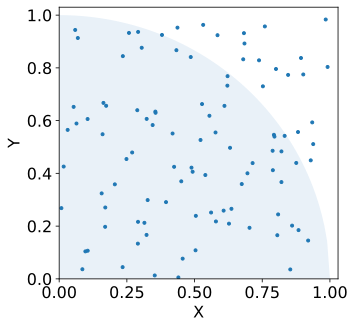

In [2]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
x = np.linspace(0,1,100)
plt.fill_between(x, np.sqrt(1-x**2),0,alpha=0.1)
plt.xlim(0,1.03);plt.ylim(0,1.03);plt.xlabel('X');plt.ylabel('Y');

x = np.random.random(size=100)
y = np.random.random(size=100)

plt.plot(x,y,marker='.',linestyle='None');


In [3]:
def pi_mc(seed):
    num_trials = 500000
    counter = 0
    np.random.seed(seed)
    
    for j in range(num_trials):
        x_val = np.random.random_sample()
        y_val = np.random.random_sample()

        radius = x_val**2 + y_val**2

        if radius < 1:
            counter += 1
            
    return 4*counter/num_trials

### Serial vs Parallel

In [4]:
%timeit pi_mc(1)

880 ms ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
seed_array = list(range(4))
%timeit list(map(pi_mc, seed_array))

3.59 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit

with multiprocessing.Pool(processes=2) as pool:
    result = pool.map(pi_mc, seed_array)

While the serial execution scales up linearly (~4x longer than one loop), the parallel execution doesn't quite reach the single loop performance. There is some overhead in setting up the threads that needs to be considered.

## Example 2: Processing multiple input files

Say we have a number of input files, like `.jpg` images, that we want to perform the same actions on, like rotate by 180 degrees and convert to a different format. 

We can define a function that takes a file as input and performs these actions, then map it on a list of files.


In [3]:
# import python image library functions
from PIL import Image

from matplotlib.pyplot import imshow
%matplotlib inline

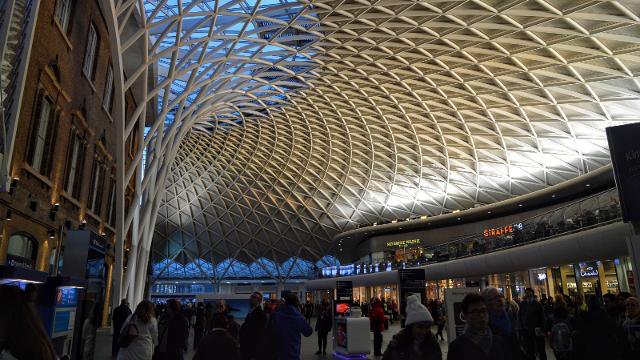

In [4]:
#Read image
im = Image.open( './data/kings_cross.jpg' )
#Display image
im

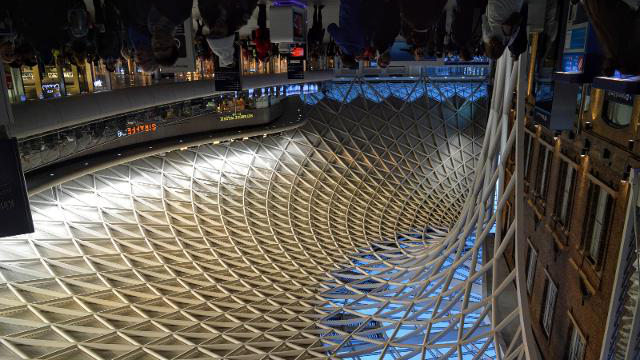

In [5]:
im.rotate(angle=180)

Let's define a function that takes a file name as input, opens the file, rotates it upside down, and then saves the output as a PDF:

In [6]:
def image_flipper(file_name):
    # extract the base file name
    base_name = file_name[0:-4]
    
    # opens the file
    im = Image.open( file_name )

    # rotates by 180deg
    im_flipped = im.rotate(angle=180)
    
    # Saves a PDF output with a new file name
    im_flipped.save(base_name + "_flipped.pdf", format='PDF')

In [7]:
file_list = glob.glob('./data/*jpg')

for f in file_list:
    print(f)

./data\charing_cross.jpg
./data\euston.jpg
./data\fenchurch.jpg
./data\kings_cross.jpg
./data\liverpool_street.jpg
./data\london_bridge.jpg
./data\paddington.jpg
./data\st_pancras.jpg
./data\victoria.jpg
./data\waterloo.jpg


In [8]:
with multiprocessing.Pool(processes=2) as pool:
    pool.map(image_flipper, file_list)

We have created a set of PDF files with new file names and inverted images. 

In [21]:
%ls ./data/*pdf

./data/charing_cross_flipped.pdf     ./data/london_bridge_flipped.pdf
./data/euston_flipped.pdf            ./data/paddington_flipped.pdf
./data/fenchurch_flipped.pdf         ./data/st_pancras_flipped.pdf
./data/kings_cross_flipped.pdf       ./data/victoria_flipped.pdf
./data/liverpool_street_flipped.pdf  ./data/waterloo_flipped.pdf


![](./data/euston_flipped.pdf)

# Embarassingly Parallel Processing on the Clusters


We can employ these tools and techniques to run parallel workers on the large-scale computing clusters maintained by YCRC. 

We highly recommend utilizing a tool called `Dead Simple Queue`.

# Dead Simple Queue

Similar to the `map` functionality discussed earlier is the Dead Simple Queue (`dSQ`, [docs](https://docs.ycrc.yale.edu/clusters-at-yale/job-scheduling/dsq/)) module available on each cluster. 
    
    module load dSQ

With this we have access to a simple way to map a function across a job array. 

The basic idea is similar to `map`: create a list of parameters and pass them to a single function for processing. 

However, instead of doing this from within `python`, we leverage the Slurm job scheduler to divy jobs to workers. 

The key is the `jobfile`. Each line of this text file is a separate command-line job that we want to pass to a different worker. 

## dSQ Output

You can monitor the status of your jobs in Slurm by using `squeue -u <netid>`.

dSQ creates a file named `job_<jobid>_status.tsv`, which will report the success or failure of each job as it finishes. Note this file will not contain information for any jobs that were canceled (e.g. by the user with scancel) before they began. This file contains details about the completed jobs in the following tab-separated columns:

    Job_ID: the zero-based line number from your job file
    Exit_Code: exit code returned from your job (non-zero number generally indicates a failed job)
    Time_Started: time started, formatted as year-month-day hour:minute:second
    Time_Ended: time started, formatted as year-month-day hour:minute:second
    Time_Elapsed: in seconds
    Job: the line from your job file

Additionally, Slurm will honor the `-e,--error` and `-i,--input` arguments you provide to capture stdout and stderr. By default both standard output and standard error are directed to a file of the name `"slurm-%j.out"`, where the "%j" is replaced with the job allocation number and array index, which is conveniently also the 0-based line number from your job file. We recommend inspecting these outputs for troubleshooting individual failed jobss.

# dSQ Example 1: Flipping Images

We can extend the example from before to be deployed on the clusters.

Our python script (`image_flipper.py`) now looks like this:

```python    

    from PIL import Image
    from sys import argv
    
    # get the command line argument (argv[0] is the function name, argv[1] is the first argument)
    file_name = argv[1]
    
    # extract the base file name
    base_name = file_name.split('.')[0]
    
    # opens the file
    im = Image.open( file_name )

    # rotates by 180deg
    im_flipped = im.rotate(angle=180)
    
    # Saves a PDF output with a new file name
    im_flipped.save(base_name + "_flipped.pdf")
```


Then we need to create the `jobfile.txt`:


In [22]:
for file_name in file_list:
    print(f'python image_flipper.py {file_name}')

python image_flipper.py ./data/waterloo.jpg
python image_flipper.py ./data/victoria.jpg
python image_flipper.py ./data/paddington.jpg
python image_flipper.py ./data/charing_cross.jpg
python image_flipper.py ./data/euston.jpg
python image_flipper.py ./data/kings_cross.jpg
python image_flipper.py ./data/fenchurch.jpg
python image_flipper.py ./data/liverpool_street.jpg
python image_flipper.py ./data/st_pancras.jpg
python image_flipper.py ./data/london_bridge.jpg


This can then be saved (`jobfile.txt`) passed to dSQ:

    dSQ --jobfile jobfile.txt --cpus-per-task=1 --mem-per-cpu=5G --time=2:00:00
    
Which outputs a Slurm submission script:

    #!/bin/bash
    #SBATCH --array 0-9
    #SBATCH --output dsq-jobfile-%A_%1a-%N.out
    #SBATCH --job-name dsq-jobfile
    #SBATCH --cpus-per-task=1 --mem-per-cpu=5G --time=2:00:00

    # DO NOT EDIT LINE BELOW
    /gpfs/loomis/apps/avx/software/dSQ/1.05/dSQBatch.py --job-file 
    /gpfs/loomis/home.grace/tl397/ycrc/workshops/parallel_python/jobfile.txt --status-dir /gpfs/loomis/home.grace/tl397/ycrc/workshops/parallel_python

We can either save this output as a sbatch submission script (and then run it: `sbatch run.sh`), or we can add the ``--submit`` flag to the dSQ command which will automatically submit the job array:

    dSQ --job-file jobfile.txt --submit
    
We can also add any further Slurm arguments that we need:

    dSQ --job-file jobfile.txt --submit --partition day -t 6:00:00 --mem-per-cpu 10000 --cpus-per-task=1

This will submit our job to the `day` partition while requesting one CPU for each task, 10GB of memory per CPU, and a wall time of 6 hours.

# Not-so-embarassingly Parallel Problems


There are also many problems that cannot be so easily split up. Many problems need to have communication between different steps and we would like a way to send messages between processes. 

Examples of this include simulations of galaxy formation and electic field simulations, analysis of a single large dataset, or complex `search` or `sort` algorithms.

# `mpi4py`

There is a standard protocol, called `MPI`, that defines how messages are passed between processes, including one-to-one and broadcast communications. 

The Python module for this is called `mpi4py`:

[mpi4py Read The Docs](https://mpi4py.readthedocs.io/en/stable/)

_Message Passing Interface implemented for Python._

> Supports point-to-point (sends, receives) and collective (broadcasts, scatters, gathers) communications of any picklable Python object, as well as optimized communications of Python object exposing the single-segment buffer interface (NumPy arrays, builtin bytes/string/array objects)

We will go over a few simple examples here.


## First, a few definitions

`COMM`: The communication "world" defined by MPI

`RANK`: an ID number given to each internal process to define communcation

`SIZE`: total number of processes allocated



`BROADCAST`: One-to-many communication

`SCATTER`: One-to-many data distribution

`GATHER`: Many-to-one data distribution


## Installing mpi4py

By far the easiest way to install mpi4py is using Anaconda, which will also install dependences (including `MPI`).

On your personal machine, run the following:

    conda create --name mpi python=3.8 mpi4py numpy scipy
    
This creates a new `conda` environment named `mpi` with various dependences.

On the clusters, you can use the `miniconda` tool to help create this environment

    module load miniconda
    conda create --name mpi python=3.8 mpi4py numpy scipy 

## MPI Example 1: RANK

`mpi4py` doesn't run well in a notebook, so we will make a file (`mpi_simple.py`) containing the following:
    
```python
from mpi4py import MPI

# instantize the communication world 
comm = MPI.COMM_WORLD

# get the size of the communication world 
size = comm.Get_size()

# get this particular processes' `rank` ID
rank = comm.Get_rank()

PID = os.getpid()

print(f'rank: {rank} has PID: {PID}')
```

We then execute this code (named `mpi_simple.py`) by running the following on the command line:

    mpirun -n 4 python mpi_simple.py



Which outputs the following:

    rank: 0 has PID: 89134 
    rank: 1 has PID: 89135 
    rank: 2 has PID: 89136
    rank: 3 has PID: 89137

    mpirun -n 4 python mpi_simple.py

The `mpirun` command is a wrapper for the MPI interface. 

Then we tell that to set up a `COMM_WORLD` with 4 workers. 

Finally we tell `mpirun` to run `python mpi_simple.py` on each of the four workers.

## Point to Point Communicators

The most basic communication operators are "`send`" and "`recv`". These can be a bit tricky since they are "blocking" commands and can cause the program to hang. 

    comm.send(obj, dest, tag=0)
    comm.recv(source=MPI.ANY_SOURCE, tag=MPI.ANY_TAG, status=None)
- `tag` can be used as a filter
- `dest` must be a rank in the current communicator
- `source` can be a rank or a wild-card (`MPI.ANY_SOURCE`)
- `status` used to retrieve information about recv'd message

# MPI Example 2: `send` and `recv`

We now we create a file (`mpi_comm.py`) that contains the following:

```python
from mpi4py import MPI
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

if rank == 0:
    msg = 'Hello, world'
    comm.send(msg, dest=1)
elif rank == 1:
    s = comm.recv()
    print(f"rank {rank}: {s}")

```

When we run this on the command line (`mpirun -n 4 python mpi_comm.py`) we get the following:

    rank 1: Hello, world
    

The `RANK=0` process sends the message, and the `RANK=1` process receives it. The other two processes are effectively bystanders in this example. 

# MPI Example 3: Broadcast

Now we will try a slightly more complicated example that involves sending messages between processes. 
```python
# Import MPI
from mpi4py import MPI

# Define world 
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# Create some data in the RANK_0 worker
if rank == 0:
    data = {'key1' : [7, 2.72, 2+3j], 'key2' : ( 'abc', 'xyz')}
else:
    data = None

# Broadcast the data from RANK_0 to all workers
data = comm.bcast(data, root=0)

# Append the RANK ID to the data
data['key1'].append(rank)

# Print the resulting data
print(f"Rank: {rank}, data: {data}")
```

We then execute this code (named `mpi_message.py`) by running the following on the command line:

    mpirun -n 4 python mpi_message.py


Which outputs the following:

    Rank: 0, data: {'key1': [7, 2.72, (2+3j), 0], 'key2': ('abc', 'xyz')}
    Rank: 2, data: {'key1': [7, 2.72, (2+3j), 2], 'key2': ('abc', 'xyz')}
    Rank: 3, data: {'key1': [7, 2.72, (2+3j), 3], 'key2': ('abc', 'xyz')}
    Rank: 1, data: {'key1': [7, 2.72, (2+3j), 1], 'key2': ('abc', 'xyz')}

# MPI Example 4: Scatter and Gather

```python

# import libraries
from mpi4py import MPI
import numpy as np

# set up MPI world
comm = MPI.COMM_WORLD
size = comm.Get_size() # new: gives number of ranks in comm
rank = comm.Get_rank()

# generate a large array of data on RANK_0
numData = 100000000 # 100milion values each
data = None
if rank == 0:
    data = np.random.normal(loc=10, scale=5, size=numData)

# initialize empty arrays to receive the partial data
partial = np.empty(int(numData/size), dtype='d')

# send data to the other workers
comm.Scatter(data, partial, root=0)

# prepare the reduced array to recieve the processed data
reduced = None
if rank == 0:
    reduced = np.empty(size, dtype='d')

# Average the partial arrays, and then gather them to RANK_0
comm.Gather(np.average(partial), reduced, root=0)

if rank == 0:
    print('Full Average:',np.average(reduced))
```

Again we execute this on the command line (`mpirun -n 4 python mpi/mpi_scatter.py`)

Which prints: `Full Average: 10.00002060397186`

# Key Take-aways

1. `MPI` is a powerful tool to set up communication worlds and send data and messages between workers
2. The `mpi4py` module provides tools for using MPI within python. 
3. This is just the begining, `mpi4py` can be used for so much more...

# GPU Parallelism

## CPU vs GPU

- CPU (Central Processing Unit) 
    - highly flexible computing elements, capable of doing any task required
    - Few very fast cores with large slow-access memory

- GPU (Graphics Processing Unit):
    - developed to handle very specific tasks, like ray-tracing and image rendering
    - 1000s of cores with small high-speed memory

- Some problems can be effectively split across the GPU cores for incredible speed-ups

## Vectorized Functions

- Vectorization: Applying the same function to every element of an array
- Example 1: Operate a function on each element of an array
- Example 2: matrix multiplication with large matrices (10k x 10k)


## GPUs on the Clusters

- We have a collection of GPUs available on Farnam and Grace
- Requesting these resources is straightforward ([YCRC docs](http://docs.ycrc.yale.edu/clusters-at-yale/job-scheduling/resource-requests/#request-gpus)), and only envolves adding a few flags to your `srun` or `sbatch` commands:

`srun --pyt --x11 -p gpu_devel -t 2:00:00 --gres=gpu:1 bash`

- This will request one GPU (a "general resource" or `gres`) from the `gpu_devel` partition
- Similar commands can be added to batch SLURM scripts and run on the `gpu` partition

## PyCUDA
_https://documen.tician.de/pycuda/_

- Python connection to NVIDIA's CUDA GPU framework
- Low-level code written in C++, but all the mess is abstracted away
- Still rather complex to work with, but very powerful

## Cupy

_https://docs-cupy.chainer.org/en/stable/_

- Drop-in replacement for numpy (fully compatible API)
- Allows for near seamless GPU-based computation 
- Matrix multiplication, vector operations, etc.

Easily installed via `conda` after loading the `CUDA` module on the clusters


In [23]:
# Load CUPY module
import cupy as cp

First, let's define a test routine with `numpy`

In [24]:
%%timeit

# Create 2D numpy arrays
a = np.random.random(25000000)
a = a.reshape(5000,5000)

b = np.random.random(25000000)
b = b.reshape(5000,5000)

# Matrix Mult
out = np.matmul(a,b)


1 loop, best of 5: 3.81 s per loop


Now, let's perform the same code but running the multiplication on the GPU

In [25]:
%%timeit

# Create 2D numpy arrays
a = np.random.random(25000000)
a = a.reshape(5000,5000)

b = np.random.random(25000000)
b = b.reshape(5000,5000)

# Move to GPU
g = cp.asarray(a)
h = cp.asarray(b)

# Matrix Mult
out = cp.matmul(g,h)

1 loop, best of 5: 476 ms per loop


Considerablly faster matrix multiplication without any complicated parallel work!

## Example: NYC Taxi Cab Data
- Get the list of NYC taxi cab data [link](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- Each month of data is ~1GB text file, we've grabbed all of 2017

### Load data using Pandas
Pandas has very friendly tools for reading data, we will use the `read_csv` method to read our Taxi Cab data before converting it to numpy arrays

In [26]:
january = pd.read_csv('../taxi/yellow_tripdata_2017-01.csv', nrows=1000000)
july = pd.read_csv('../taxi/yellow_tripdata_2017-07.csv', nrows=1000000)

In [27]:
tip_jan = np.array(january['tip_amount'])
distance_jan = np.array(january['trip_distance'])

tip_jul = np.array(july['tip_amount'])
distance_jul = np.array(july['trip_distance'])

### Move data to GPU

Cupy has built-in tools to move data to and from GPUs, `cp.asarray()` and `cp.asnumpy`. We will use these to analyze data from the Taxi Cab dataset.

In [28]:
gpu_tip_jan = cp.asarray(tip_jan)
gpu_dist_jan = cp.asarray(distance_jan)

gpu_tip_jul = cp.asarray(tip_jul)
gpu_dist_jul = cp.asarray(distance_jul)

### Comparison of CPU and GPU performance

In [29]:
%%timeit
np.divide(tip_jan, distance_jan)

1000 loops, best of 5: 1.43 ms per loop


In [30]:
%%timeit 
gpu_tip_per_mile = cp.divide(gpu_tip_jan, gpu_dist_jan)

The slowest run took 50762.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 8.65 µs per loop


## Visualizing Results

Data have to be pulled off the GPU to be able to visualize them. 

January Average: 1.004
July Average: 0.962


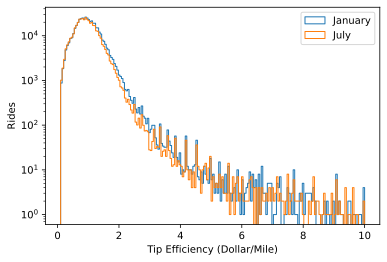

In [31]:
gpu_tip_per_mile = cp.divide(gpu_tip_jan, gpu_dist_jan)
tpm = cp.asnumpy(gpu_tip_per_mile)[(tip_jan > 0) & (distance_jan > 1)]

plt.hist(tpm, bins=200, range=(0.1,10), histtype='step', label='January');
print(f'January Average: {np.mean(tpm[(tpm>0)&(tpm<10)]):.3f}')

gpu_tip_per_mile = cp.divide(gpu_tip_jul, gpu_dist_jul)
tpm = cp.asnumpy(gpu_tip_per_mile)[(tip_jul > 0) & (distance_jul > 1)]

plt.hist(tpm, bins=200, range=(0.1,10), histtype='step', label='July');
print(f'July Average: {np.mean(tpm[(tpm>0)&(tpm<10)]):.3f}')

plt.xlabel('Tip Efficiency (Dollar/Mile)');plt.ylabel('Rides');plt.yscale('log');plt.legend();

## GPU Summary

- There are a ton of exciting projects that are starting to utilize GPUs. 
- Having python connection to these tools enable rapid work with machine learning or other computationally intensive tasks
- Make use of the GPUs in the clusters to get started with this kind of tool

# Outlook and Further Reading

Parallel processing is a vast topic with numerous posibilities of study. This tutorial is designed to give a flavor of some of the tools available in Python for small, medium, and large-scale parallel programming. 

There are some fantastic tutorials available for further study. I recommend the following:

## Intro
- [Python 201: A multiprocessing tutorial | The Mouse Vs. The Python](https://www.blog.pythonlibrary.org/2016/08/02/python-201-a-multiprocessing-tutorial/)
- [Parallelism in one line - Blogomatono](http://chriskiehl.com/article/parallelism-in-one-line/)
- [An introduction to parallel programming using Python’s multiprocessing module](https://sebastianraschka.com/Articles/2014_multiprocessing.html)
- [Python Parallel Computing (in 60 Seconds or less) – dbader.org](https://dbader.org/blog/python-parallel-computing-in-60-seconds)

## Advanced
- [Parallel Programming with MPI For Python - Research Computing in Earth Sciences](https://rabernat.github.io/research_computing/parallel-programming-with-mpi-for-python.html)
- [Parallel Computing in Python using mpi4py by Stephen Weston](https://github.com/ycrc/parallel_python/blob/master/mpi/mpi4py.pdf)

## GPU Parallelism
- [CuPy, a Numpy-like API for GPU processing](https://docs-cupy.chainer.org/en/stable/)
- [PyCUDA, CUDA API for python](https://documen.tician.de/pycuda/)
- [RAPIDS, GPU-accelerated data science](https://rapids.ai)

# Thanks!

Please fill out a survey before you leave!
